## Facial recognition tutorial

**Objective**
* Understanding how to construct a data pipline using tensorflow.
* Geting to know some method for images augmentation.
* Introduction about center loss.
* What is embedding.

**What we are gonna do**
* Train a face classification model using convolution neural network
![Training Network](doc/training_net.png)
* Use the trained network for embedding to produce latent vectors of the faces
* Using latent vectors to recognize faces by comparing the distance between them
![Training Network](doc/embedding.png)

In [31]:
# import stuff we need
import math
import cv2
import tensorflow as tf
import tensorflow.contrib.slim as slim
import inception_resnet_v1 as model
import data_utils
import model_utils
import numpy as np
import glob
from matplotlib import pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import data_flow_ops
from tensorflow.python.ops import array_ops

from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input

In [2]:
# some config
data_dir = 'data/CASIA-WebFace_mtcnn_182/' # data directory containing aligned face patches
validation_set_split_ratio = 0.3
max_nrof_epochs = 50
validate_every_n_epochs = 1
batch_size = 256
image_size = (160, 160)
epoch_size = 1000 # number of batch per epoch
embedding_size = 512 # Dimensionality of the embedding
random_crop = True # augmentation
random_flip = True # augmentation
random_rotate = True # augmentation
keep_prob = 0.8
min_nrof_val_images_per_class = 0 # minimum number of image per class

### Dataset preparation
For this project I have prepared a dataset that contains faces cropped from Cassia Webface dataset. You can download it [here](https://my.pcloud.com/publink/show?code=XZWjK37ZIVmQnMnQ1KuczvGWrG3BuJXfe0uV). Download and decompress the dataset into 'data' folder.

The code bellow does 2 things:
* Load the dataset
* split into training and test set

In [59]:

dataset = data_utils.get_dataset(data_dir)
if validation_set_split_ratio > 0:
    train_set, val_set = data_utils.split_dataset(
            dataset, validation_set_split_ratio, min_nrof_val_images_per_class, 'SPLIT_IMAGES')
else:
    train_set, val_set = data_utils.split_dataset(
            dataset, validation_set_split_ratio, min_nrof_val_images_per_class, 'SPLIT_IMAGES')

In [60]:
# Let's take a look at the dataset
print(type(train_set))
print(len(train_set))
print(train_set[: 5])
print(train_set[0])

<class 'list'>
10575
[<data_utils.ImageClass object at 0x12e513518>, <data_utils.ImageClass object at 0x12e5138d0>, <data_utils.ImageClass object at 0x12e513860>, <data_utils.ImageClass object at 0x12e513160>, <data_utils.ImageClass object at 0x12e513828>]
0000045, 3 images


### Prepare the input pipline for training
2 steps:
* Randomly generate indexes of the images and their labels with 'index_queue'
* With the indexes of images and labels generated by 'index_queue', read those images and their labels and put it into 'input_queue'. From this, add some augmentation and processing to finish the queue

These step can be simplified a lot by using [tf.data](https://www.tensorflow.org/api_docs/python/tf/data) (HomeWork)

In [ ]:
df_graph = tf.Graph()

# number of class for the classification model
nrof_classes = len(train_set)

with df_graph.as_default():
    # Get a list of image paths and their labels
    image_list, label_list = data_utils.get_image_paths_and_labels(train_set)
    assert len(image_list) > 0, 'The training set should not be empty'

    val_image_list, val_label_list = data_utils.get_image_paths_and_labels(val_set)

    # Create a queue that produces indices into the image_list and label_list
    labels = ops.convert_to_tensor(label_list, dtype=tf.int32)
    range_size = array_ops.shape(labels)[0]
    index_queue = tf.train.range_input_producer(range_size, num_epochs=None,
                                                shuffle=True, seed=None, capacity=32)

    index_dequeue_op = index_queue.dequeue_many(batch_size*epoch_size, 'index_dequeue')
    
    # list of placehodler for the data pipeline
    image_paths_placeholder = tf.placeholder(tf.string, shape=(None, 1), name='image_paths')
    labels_placeholder = tf.placeholder(tf.int32, shape=(None, 1), name='labels')
    control_placeholder = tf.placeholder(tf.int32, shape=(None, 1), name='control')

    nrof_preprocess_threads = 4
    input_queue = data_flow_ops.FIFOQueue(capacity=2000000,
                                          dtypes=[tf.string,
                                                  tf.int32, tf.int32],
                                          shapes=[(1,), (1,), (1,)],
                                          shared_name=None, name=None)
    enqueue_op = input_queue.enqueue_many(
        [image_paths_placeholder, labels_placeholder, control_placeholder], name='enqueue_op')
    image_batch, label_batch = data_utils.create_input_pipeline(
        input_queue, image_size, nrof_preprocess_threads, batch_size)
    
    image_batch = tf.identity(image_batch, 'input')
    label_batch = tf.identity(label_batch, 'label_batch')

### Build the model
For the embedding part, we use Inception ResNet version 1.

The latent vectors produced by embedding layers are then fed into a fully connected layer to perform classification.

Our target is the embedding vectors which are latent vectors normalized using l2_norm.

In [ ]:
 with df_graph.as_default():
    # training phase placeholder
    phase_train_placeholder = tf.placeholder(tf.bool, name='phase_train')

    # build the model here
    prelogits, _ = model.inference(image_batch, keep_prob,
                                 phase_train=phase_train_placeholder, bottleneck_layer_size=embedding_size)
    logits = slim.fully_connected(prelogits, nrof_classes, activation_fn=None,
                                  weights_initializer=slim.initializers.xavier_initializer(),
                                  weights_regularizer=slim.l2_regularizer(
                                      5e-4),
                                  scope='Logits', reuse=False)
    
    embeddings = tf.nn.l2_normalize(prelogits, 1, 1e-10, name='embeddings')

### Losses and optimizer

We use 2 losses for this project: center loss and cross-entropy loss

**Center loss**
The idea is that we define the outputs from the second last layers of the neural network as embeddings. For this loss, we define a per class center which serves as the centroid of embeddings corresponding to that class. We would want the embedding of a sample to be as close as possible to the centoid of its class. The center loss term is then defined as:

$$ L_C = \frac{1}{m} \sum_{i = 1}^{m} \left \| x_i = c_{y_i}  \right \|^2 $$

The effect of this loss:
![MNIST trained with center loss](https://cdn-images-1.medium.com/max/800/1*Tg5GHsnOKBpXkbYMy86vcg.png)

Find out more about this loss [here](http://ydwen.github.io/papers/WenECCV16.pdf)

**Cross-entropy loss** C'mon, we don't need to talk about this

For the optimizer, we use out-of-the-box Adam optimizer

In [ ]:
with df_graph.as_default():
    # Add center loss
    prelogits_center_loss, _ = model_utils.center_loss(
        prelogits, label_batch, 0.95, nrof_classes)
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES,
                         prelogits_center_loss * 0.01)
    
    # Calculate the average cross entropy loss across the batch
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=label_batch, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(
        cross_entropy, name='cross_entropy')
    tf.add_to_collection('losses', cross_entropy_mean)
    
    correct_prediction = tf.cast(
    tf.equal(tf.argmax(logits, 1), tf.cast(label_batch, tf.int64)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
    # Calculate the total losses
    regularization_losses = tf.get_collection(
        tf.GraphKeys.REGULARIZATION_LOSSES)
    total_loss = tf.add_n([cross_entropy_mean] +
                          regularization_losses, name='total_loss')
    
    # optimizer an train_op
    train_op = tf.train.AdamOptimizer(0.0001).minimize(total_loss)

Time to train the model

In [ ]:
 with df_graph.as_default():
    global_step = tf.Variable(0, trainable=False)
    
    # Create a saver
    saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=3)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    tf.train.start_queue_runners(coord=coord, sess=sess)
    with sess.as_default():
        # Training and validation loop
        print('Running training')
        nrof_steps = max_nrof_epochs*epoch_size
        # Validate every validate_every_n_epochs as well as in the last epoch
        nrof_val_samples = int(
            math.ceil(max_nrof_epochs / validate_every_n_epochs))
        
        for epoch in range(1, max_nrof_epochs+1):
            print('epoch ', epoch)
            step = sess.run(global_step, feed_dict=None)
            batch_number = 0
            
            # get index of images and labels
            index_epoch = sess.run(index_dequeue_op)
            label_epoch = np.array(label_list)[index_epoch]
            image_epoch = np.array(image_list)[index_epoch]

            # Enqueue one epoch of image paths and labels
            labels_array = np.expand_dims(np.array(label_epoch), 1)
            image_paths_array = np.expand_dims(np.array(image_epoch), 1)
            control_value = data_utils.RANDOM_ROTATE + data_utils.RANDOM_CROP + data_utils.RANDOM_FLIP + \
                data_utils.FIXED_STANDARDIZATION
            control_array = np.ones_like(labels_array) * control_value
            sess.run(enqueue_op, {image_paths_placeholder: image_paths_array,
                                  labels_placeholder: labels_array, control_placeholder: control_array})
            
            # batch loop
            while batch_number < epoch_size:
                feed_dict = {phase_train_placeholder: True}
                tensor_list = [total_loss, train_op, global_step, accuracy]

                loss_, _, step_, accuracy_ = sess.run(tensor_list, feed_dict=feed_dict)
                print(loss_)

                batch_number += 1

It'll take a lot of time to train this model. Luckily, we have a pre-trained model provided [here](https://drive.google.com/open?id=1R77HmFADxe87GmoLwzfgMu_HY0IhcyBz) by a [random good guy](https://github.com/davidsandberg) on the internet so we don't have to sit through few tedious days to watch the model training.

Dowload it and unzip into pretrained_models folder.

Rename the folder into something that easy to remember, something like 'inceptionv1' and we are ready for some classification.

### Load the pretrained model

In [3]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="model")
    return graph

In [4]:
GRAPH_PB_PATH = './pretrained_models/inceptionv1/20180408-102900.pb'
graph = load_graph(GRAPH_PB_PATH)

In [5]:
for op in graph.get_operations():
    print(op.name)

model/batch_size
model/phase_train
model/batch_join/fifo_queue
model/batch_join
model/image_batch
model/input
model/label_batch
model/InceptionResnetV1/Conv2d_1a_3x3/weights
model/InceptionResnetV1/Conv2d_1a_3x3/weights/read
model/InceptionResnetV1/Conv2d_1a_3x3/Conv2D
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/beta
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/beta/read
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/Const
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/moving_mean
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/moving_mean/read
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/moving_variance
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/moving_variance/read
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/cond/Switch
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/cond/switch_t
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/cond/pred_id
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/cond/Const
model/InceptionResnetV1/Conv2d_1a_3x3/BatchNorm/cond/Const_1
mode

model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/switch_t
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/pred_id
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/AssignMovingAvg/decay
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/AssignMovingAvg/sub/Switch
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/AssignMovingAvg/sub/Switch_1
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/AssignMovingAvg/sub
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/AssignMovingAvg/mul
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/AssignMovingAvg/Switch
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/cond_1/AssignMovingAvg
model/InceptionResnetV1/Repeat_1/block17_2/Branch_1/Conv2d_0c_7x1/BatchNorm/con

model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/pred_id
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/AssignMovingAvg/decay
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/AssignMovingAvg/sub/Switch
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/AssignMovingAvg/sub/Switch_1
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/AssignMovingAvg/sub
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/AssignMovingAvg/mul
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/AssignMovingAvg/Switch
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/AssignMovingAvg
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNorm/cond_1/AssignMovingAvg_1/decay
model/InceptionResnetV1/Repeat_2/block8_2/Branch_1/Conv2d_0c_3x1/BatchNor

In [6]:
# Get the input and embedding tensors of the network 
phase_train_placeholder = graph.get_tensor_by_name('model/phase_train:0')
image = graph.get_tensor_by_name('model/input:0')
embedding = graph.get_tensor_by_name('model/embeddings:0')

### Use the loaded network for embedding

In [35]:
def preprocess_image(image_path):
    ''' Load the image, resize and normalized it
    Note: The way we normalize the image here should be
    consistant with the way we nomalize the images while training
    '''
    
    pass

def get_embedding(image_path):
    ''' Helper function to get an embedding of a image
    Load and pre-process the image
    Feed the image into the network and get the embedding vector
    '''
    
    pass
    
def findEuclideanDistance(cand, test):
    ''' Compute euclidean distance between 2 vectors
    '''
    
    pass


<details>
<summary>Click to see the solution!</summary>

```python
def preprocess_image(image_path):
    ''' Load the image, resize and normalized it
    Note: The way we normalize the image here should be
    consistant with the way we nomalize the images while training
    '''

    img = load_img(image_path, target_size=(160, 160))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0).astype(float)
    img = (img - 127.5) / 128.0
    return img

def get_embedding(image_path):
    ''' Helper function to get an embedding of a image
    Load and pre-process the image
    Feed the image into the network and get the embedding vector
    '''

    img = preprocess_image(image_path)

    with tf.Session(graph=graph) as sess:
        emb = sess.run(embedding, feed_dict={image: img, phase_train_placeholder: False})
        return emb.squeeze()

def findEuclideanDistance(cand, test):
    ''' Compute euclidean distance between 2 vectors
    '''

    euclidean_distance = cand - test
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

```
</details>

### Use the embedding vector for recognition

Let's say we are building a face recognition system for an office with 4 people. We have in the database face images of them
![0](data/db/0.png)
![1](data/db/1.png)
![2](data/db/2.png)
![3](data/db/3.png)

Now we have a face and want to know who is this

![test](data/test_img.png)

Euclidean distance:  0.8970275


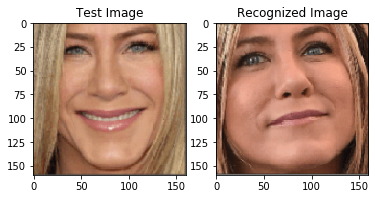

In [24]:
test_img = 'data/test_img.png'
db_imgs = glob.glob('data/db/*.png')

test_eb = get_embedding(test_img)
db_eb = [get_embedding(img_path) for img_path in db_imgs]
dt = [findEuclideanDistance(test_eb, eb) for eb in db_eb]
min_idx = np.argmin(dt)
dst_img = load_img(db_imgs[min_idx], target_size=(160, 160))

img = load_img(test_img, target_size=(160, 160))

plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Test Image')

plt.subplot(122)
plt.imshow(dst_img)
plt.title('Recognized Image')
print('Euclidean distance: ', dt[min_idx])

## Home Work Assignment
* In this notebook we used Inception Resnet V1, you should try other network.
* Reimplement the data pipline using tf.data instead of queue
* Replace euclidean distance with cosine similarity
* Read about triplet loss

In [58]:
import shutil
import os
import os.path

directories = glob.glob('data/CASIA-WebFace_mtcnn_182_full/*/')

for directory in directories:
    dest_dir = os.path.join('data/CASIA-WebFace_mtcnn_182/', os.path.split(os.path.abspath(directory))[-1])
    for i, f in enumerate(glob.glob(directory + '*')):
        dest_dir_ = dest_dir + '/' + os.path.split(os.path.abspath(f))[-1]
        os.makedirs(os.path.dirname(dest_dir_), exist_ok=True)
        shutil.copy(f, dest_dir_)
        if i == 4:
            break
